# FullClass-TrainCNN_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=224
img_width=224
batch_size=32

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


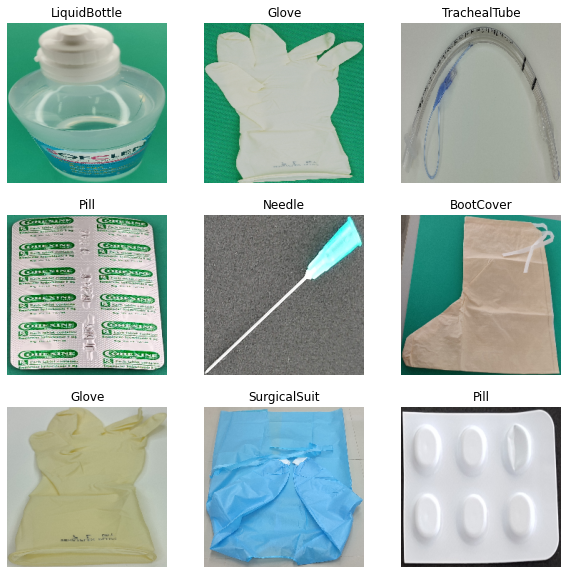

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [29]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import preprocess_input,ResNet152V2

transfered_model = keras.applications.ResNet152V2(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

model_nooutput = transfered_model.layers[-2].output
custom_model = Model(inputs = transfered_model.input, outputs = model_nooutput)


242761728/242745792 [==============================] - 450s 2us/step


## Freez Extractor+

In [30]:
custom_model.trainable = False
for layer in custom_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
#tf.keras.utils.plot_model(ResNet152_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [32]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              58331648  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 41)                42025     
Total params: 60,471,849
Trainable params: 2,140,201
Non-trainable params: 58,331,648
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/ResNet152V2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [36]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
97/97 [==============================] - 27s 210ms/step - loss: 0.9195 - accuracy: 0.7564 - val_loss: 0.2897 - val_accuracy: 0.9094
Epoch 2/2000
97/97 [==============================] - 18s 182ms/step - loss: 0.1802 - accuracy: 0.9460 - val_loss: 0.3116 - val_accuracy: 0.9288
Epoch 3/2000
97/97 [==============================] - 18s 182ms/step - loss: 0.0904 - accuracy: 0.9745 - val_loss: 0.2228 - val_accuracy: 0.9431
Epoch 4/2000
97/97 [==============================] - 18s 182ms/step - loss: 0.0481 - accuracy: 0.9874 - val_loss: 0.2742 - val_accuracy: 0.9301
Epoch 5/2000
97/97 [==============================] - 18s 182ms/step - loss: 0.0450 - accuracy: 0.9838 - val_loss: 0.2483 - val_accuracy: 0.9366
Epoch 6/2000
97/97 [==============================] - 18s 183ms/step - loss: 0.0176 - accuracy: 0.9981 - val_loss: 0.2137 - val_accuracy: 0.9483
Epoch 7/2000
97/97 [==============================] - 18s 183ms/step - loss: 0.0094 - accuracy: 0.9987 - val_loss: 0.2242 - val_ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.6219e-05 - accuracy: 1.0000 - val_loss: 0.2872 - val_accuracy: 0.9508
Epoch 202/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.2041e-05 - accuracy: 1.0000 - val_loss: 0.2854 - val_accuracy: 0.9521
Epoch 203/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.5078e-05 - accuracy: 1.0000 - val_loss: 0.2877 - val_accuracy: 0.9534
Epoch 204/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.0765e-05 - accuracy: 1.0000 - val_loss: 0.2862 - val_accuracy: 0.9534
Epoch 205/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.1949e-05 - accuracy: 1.0000 - val_loss: 0.2852 - val_accuracy: 0.9534
Epoch 206/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.6353e-05 - accuracy: 1.0000 - val_loss: 0.2823 - val_accuracy: 0.9534
Epoch 207/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.6065e-05 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.3141e-06 - accuracy: 1.0000 - val_loss: 0.3089 - val_accuracy: 0.9534
Epoch 402/2000
97/97 [==============================] - 18s 182ms/step - loss: 1.6482e-06 - accuracy: 1.0000 - val_loss: 0.3064 - val_accuracy: 0.9534
Epoch 403/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.7626e-06 - accuracy: 1.0000 - val_loss: 0.3054 - val_accuracy: 0.9534
Epoch 404/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.6144e-06 - accuracy: 1.0000 - val_loss: 0.3085 - val_accuracy: 0.9521
Epoch 405/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.1072e-06 - accuracy: 1.0000 - val_loss: 0.3158 - val_accuracy: 0.9521
Epoch 406/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.6983e-06 - accuracy: 1.0000 - val_loss: 0.3103 - val_accuracy: 0.9547
Epoch 407/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.2703e-06 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.5832e-07 - accuracy: 1.0000 - val_loss: 0.3260 - val_accuracy: 0.9534
Epoch 602/2000
97/97 [==============================] - 18s 183ms/step - loss: 4.3789e-07 - accuracy: 1.0000 - val_loss: 0.3234 - val_accuracy: 0.9534
Epoch 603/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.0031e-07 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9547
Epoch 604/2000
97/97 [==============================] - 18s 184ms/step - loss: 2.9927e-07 - accuracy: 1.0000 - val_loss: 0.3240 - val_accuracy: 0.9547
Epoch 605/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.0455e-07 - accuracy: 1.0000 - val_loss: 0.3242 - val_accuracy: 0.9547
Epoch 606/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.6460e-07 - accuracy: 1.0000 - val_loss: 0.3241 - val_accuracy: 0.9547
Epoch 607/2000
97/97 [==============================] - 18s 184ms/step - loss: 5.3301e-07 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.8129e-07 - accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.9560
Epoch 802/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.5761e-07 - accuracy: 1.0000 - val_loss: 0.3395 - val_accuracy: 0.9547
Epoch 803/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.9046e-07 - accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.9547
Epoch 804/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.0968e-07 - accuracy: 1.0000 - val_loss: 0.3395 - val_accuracy: 0.9547
Epoch 805/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.7186e-07 - accuracy: 1.0000 - val_loss: 0.3404 - val_accuracy: 0.9547
Epoch 806/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.4186e-07 - accuracy: 1.0000 - val_loss: 0.3402 - val_accuracy: 0.9547
Epoch 807/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.6150e-07 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
97/97 [==============================] - 18s 184ms/step - loss: 1.2522e-07 - accuracy: 1.0000 - val_loss: 0.3510 - val_accuracy: 0.9560
Epoch 1002/2000
97/97 [==============================] - 18s 183ms/step - loss: 1.2075e-07 - accuracy: 1.0000 - val_loss: 0.3505 - val_accuracy: 0.9560
Epoch 1003/2000
97/97 [==============================] - 18s 184ms/step - loss: 1.0704e-07 - accuracy: 1.0000 - val_loss: 0.3507 - val_accuracy: 0.9560
Epoch 1004/2000
97/97 [==============================] - 18s 184ms/step - loss: 1.1493e-07 - accuracy: 1.0000 - val_loss: 0.3515 - val_accuracy: 0.9560
Epoch 1005/2000
97/97 [==============================] - 18s 184ms/step - loss: 8.8088e-08 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.9560
Epoch 1006/2000
97/97 [==============================] - 18s 184ms/step - loss: 8.3504e-08 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.9560
Epoch 1007/2000
97/97 [==============================] - 18s 184ms/step - loss: 1.0153e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
97/97 [==============================] - 18s 183ms/step - loss: 6.7751e-08 - accuracy: 1.0000 - val_loss: 0.3561 - val_accuracy: 0.9560
Epoch 1202/2000
97/97 [==============================] - 18s 183ms/step - loss: 6.4053e-08 - accuracy: 1.0000 - val_loss: 0.3567 - val_accuracy: 0.9560
Epoch 1203/2000
97/97 [==============================] - 18s 183ms/step - loss: 7.2527e-08 - accuracy: 1.0000 - val_loss: 0.3570 - val_accuracy: 0.9560
Epoch 1204/2000
97/97 [==============================] - 18s 183ms/step - loss: 5.3923e-08 - accuracy: 1.0000 - val_loss: 0.3567 - val_accuracy: 0.9560
Epoch 1205/2000
97/97 [==============================] - 18s 183ms/step - loss: 7.1102e-08 - accuracy: 1.0000 - val_loss: 0.3569 - val_accuracy: 0.9560
Epoch 1206/2000
97/97 [==============================] - 18s 183ms/step - loss: 7.6417e-08 - accuracy: 1.0000 - val_loss: 0.3577 - val_accuracy: 0.9560
Epoch 1207/2000
97/97 [==============================] - 18s 183ms/step - loss: 7.2026e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.9403e-08 - accuracy: 1.0000 - val_loss: 0.3582 - val_accuracy: 0.9560
Epoch 1402/2000
97/97 [==============================] - 18s 183ms/step - loss: 4.3755e-08 - accuracy: 1.0000 - val_loss: 0.3584 - val_accuracy: 0.9560
Epoch 1403/2000
97/97 [==============================] - 18s 184ms/step - loss: 5.1920e-08 - accuracy: 1.0000 - val_loss: 0.3588 - val_accuracy: 0.9560
Epoch 1404/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.7862e-08 - accuracy: 1.0000 - val_loss: 0.3590 - val_accuracy: 0.9560
Epoch 1405/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.9518e-08 - accuracy: 1.0000 - val_loss: 0.3588 - val_accuracy: 0.9560
Epoch 1406/2000
97/97 [==============================] - 18s 184ms/step - loss: 7.6916e-08 - accuracy: 1.0000 - val_loss: 0.3596 - val_accuracy: 0.9560
Epoch 1407/2000
97/97 [==============================] - 18s 184ms/step - loss: 4.5450e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.6860e-08 - accuracy: 1.0000 - val_loss: 0.3653 - val_accuracy: 0.9560
Epoch 1602/2000
97/97 [==============================] - 18s 183ms/step - loss: 4.8069e-08 - accuracy: 1.0000 - val_loss: 0.3650 - val_accuracy: 0.9560
Epoch 1603/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.8517e-08 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.9560
Epoch 1604/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.5607e-07 - accuracy: 1.0000 - val_loss: 0.3654 - val_accuracy: 0.9560
Epoch 1605/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.2277e-08 - accuracy: 1.0000 - val_loss: 0.3651 - val_accuracy: 0.9560
Epoch 1606/2000
97/97 [==============================] - 18s 183ms/step - loss: 2.7501e-08 - accuracy: 1.0000 - val_loss: 0.3651 - val_accuracy: 0.9560
Epoch 1607/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.5782e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
97/97 [==============================] - 18s 184ms/step - loss: 2.8888e-08 - accuracy: 1.0000 - val_loss: 0.3686 - val_accuracy: 0.9560
Epoch 1802/2000
97/97 [==============================] - 18s 183ms/step - loss: 3.8170e-08 - accuracy: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.9560
Epoch 1803/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.6013e-08 - accuracy: 1.0000 - val_loss: 0.3696 - val_accuracy: 0.9560
Epoch 1804/2000
97/97 [==============================] - 18s 184ms/step - loss: 4.1444e-08 - accuracy: 1.0000 - val_loss: 0.3701 - val_accuracy: 0.9560
Epoch 1805/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.2855e-08 - accuracy: 1.0000 - val_loss: 0.3705 - val_accuracy: 0.9560
Epoch 1806/2000
97/97 [==============================] - 18s 184ms/step - loss: 3.5204e-08 - accuracy: 1.0000 - val_loss: 0.3705 - val_accuracy: 0.9560
Epoch 1807/2000
97/97 [==============================] - 18s 184ms/step - loss: 2.8310e-

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

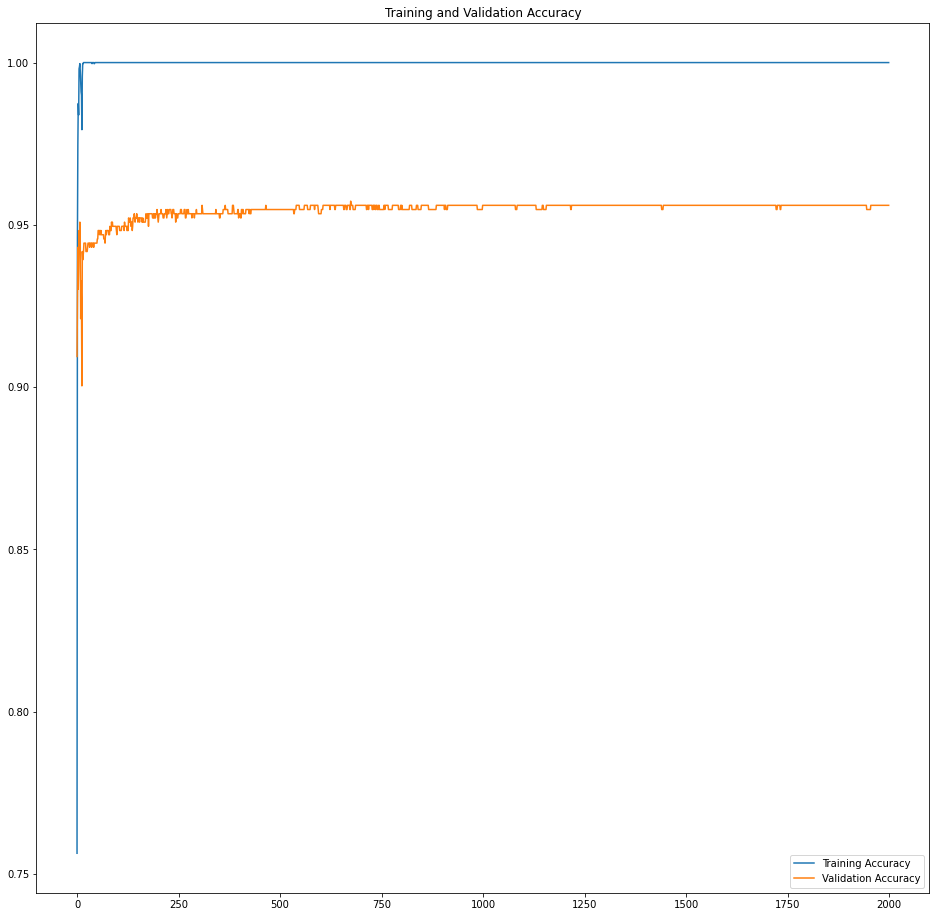

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


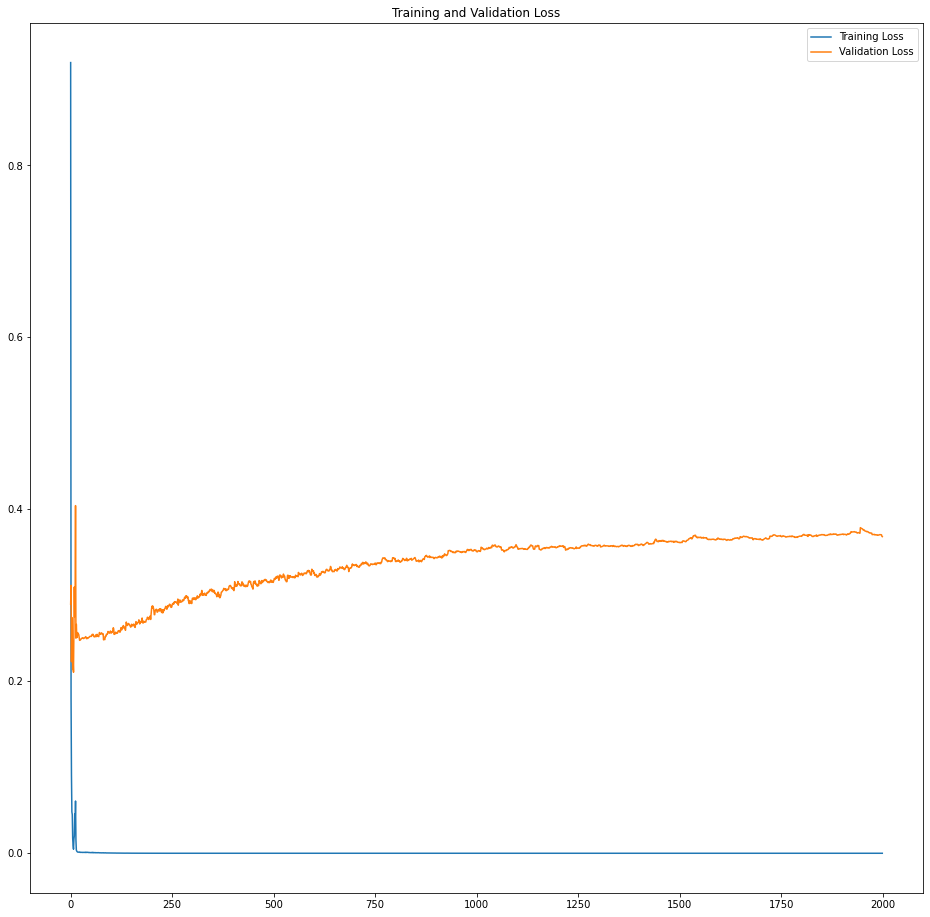

In [38]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

57/57 [==============================] - 14s 206ms/step - loss: 1.3469 - accuracy: 0.8300
test_indoor_ds_results:test loss, test acc: [1.3469152450561523, 0.8299888372421265]


In [40]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

99/99 [==============================] - 26s 233ms/step - loss: 2.3666 - accuracy: 0.7481
test_outdoor_ds_results:test loss, test acc: [2.3666274547576904, 0.7480891942977905]


In [41]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

69/69 [==============================] - 12s 159ms/step - loss: 2.5323 - accuracy: 0.7652
test_belt_ds_results:test loss, test acc: [2.5323140621185303, 0.7651858329772949]


In [42]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/ResNet152V2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/ResNet152V2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/ResNet152V2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/ResNet152V2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/ResNet152V2_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-N

# Testing in testset

In [43]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

69/69 [==============================] - 10s 148ms/step - loss: 1.8213 - accuracy: 0.7616
Epoch200 
 test_indoor_acc=0.8160535097122192 
 test_outdoor_acc=0.7423567175865173 
 test_belt_acc=0.7615593671798706
69/69 [==============================] - 10s 148ms/step - loss: 2.1284 - accuracy: 0.7634
Epoch400 
 test_indoor_acc=0.8277592062950134 
 test_outdoor_acc=0.7458598613739014 
 test_belt_acc=0.7633726000785828
69/69 [==============================] - 10s 148ms/step - loss: 2.2357 - accuracy: 0.7670
Epoch600 
 test_indoor_acc=0.8305462598800659 
 test_outdoor_acc=0.7452229261398315 
 test_belt_acc=0.7669990658760071
69/69 [==============================] - 10s 148ms/step - loss: 2.3553 - accuracy: 0.7638
Epoch800 
 test_indoor_acc=0.8277592062950134 
 test_outdoor_acc=0.7452229261398315 
 test_belt_acc=0.7638259530067444
69/69 [==============================] - 10s 148ms/step - loss: 2.4057 - accuracy: 0.7625
Epoch1000 
 test_indoor_acc=0.8283166289329529 
 test_outdoor_acc=0.744585

In [44]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

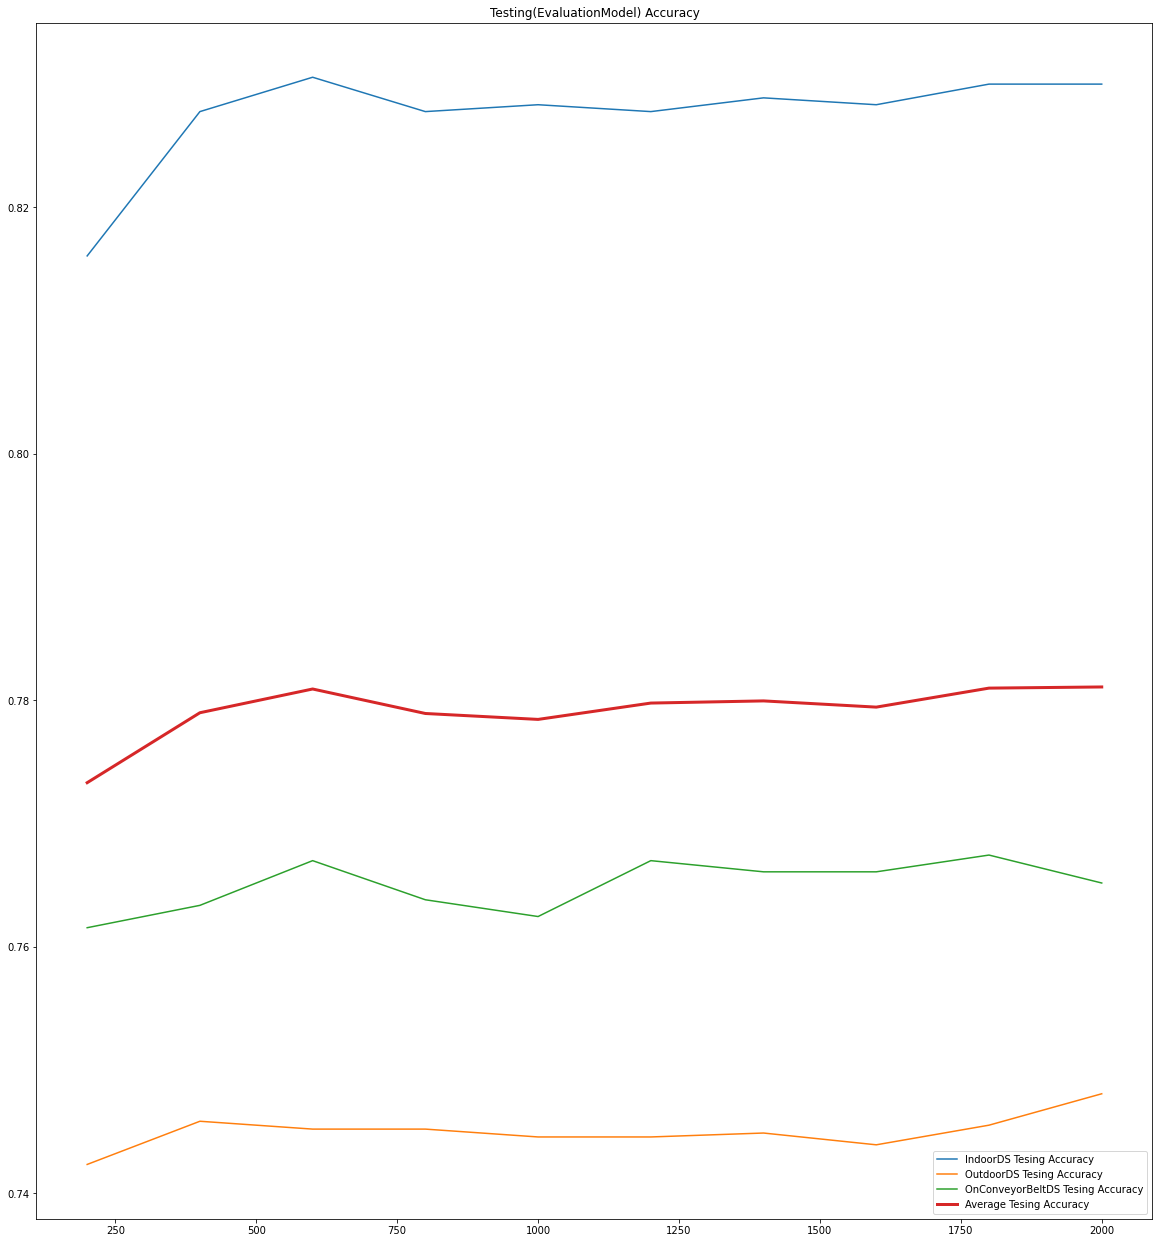

In [45]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [46]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7810879548390707
max index -> 9
The [Epoch] of max acc -> 2000


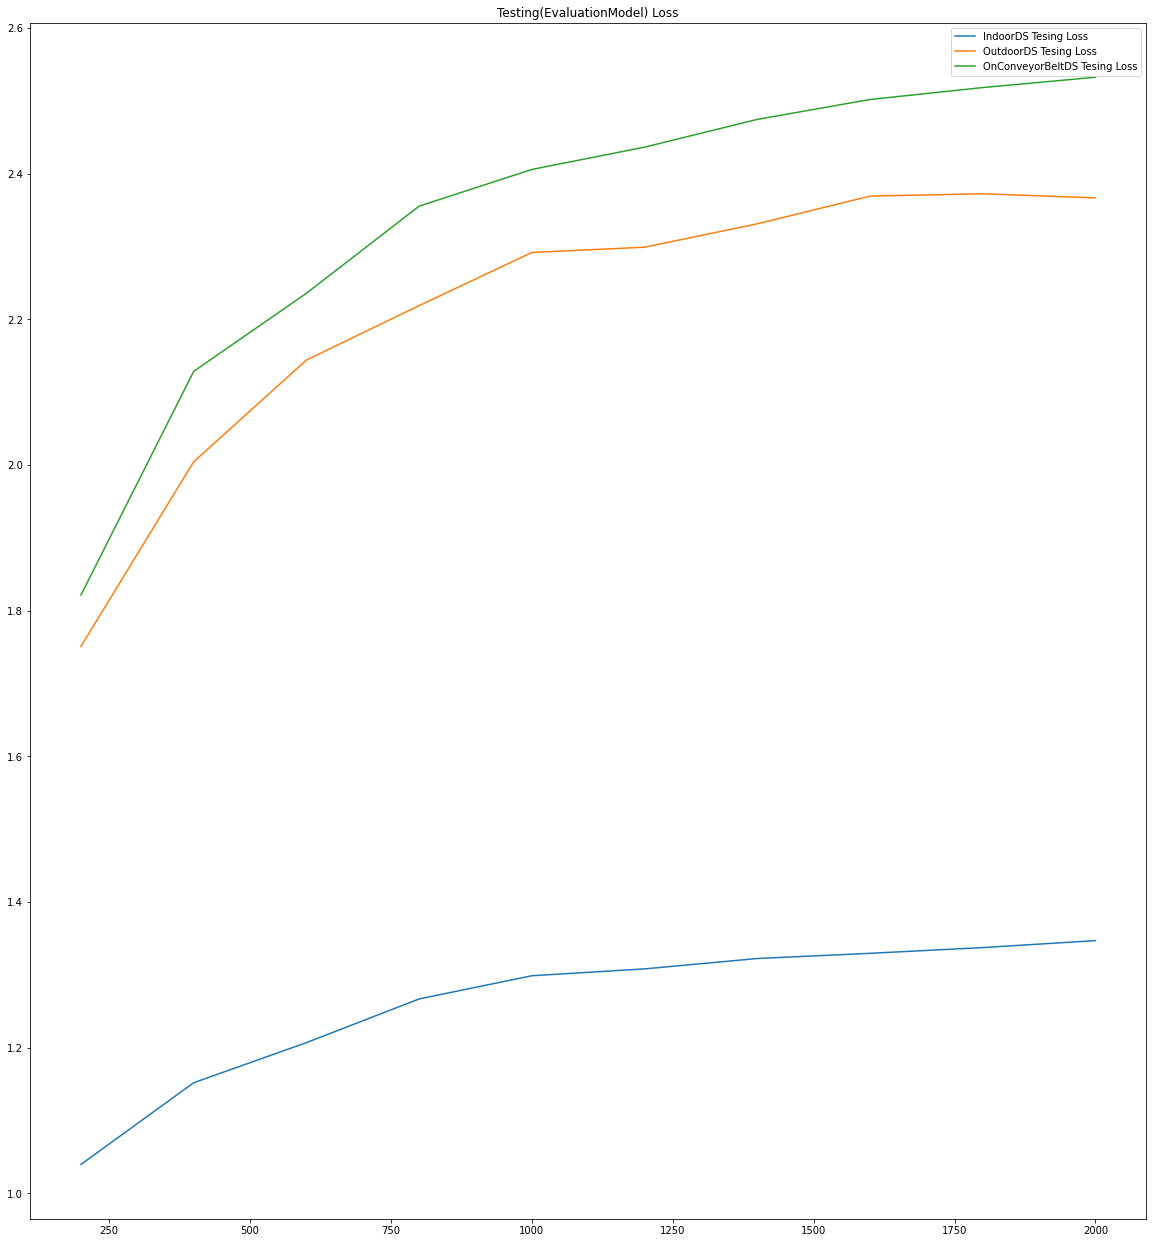

In [47]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [48]:
test_indoor_acc

[0.8160535097122192,
 0.8277592062950134,
 0.8305462598800659,
 0.8277592062950134,
 0.8283166289329529,
 0.8277592062950134,
 0.8288740515708923,
 0.8283166289329529,
 0.8299888372421265,
 0.8299888372421265]

In [49]:
test_outdoor_acc

[0.7423567175865173,
 0.7458598613739014,
 0.7452229261398315,
 0.7452229261398315,
 0.7445859909057617,
 0.7445859909057617,
 0.7449044585227966,
 0.7439490556716919,
 0.7455413937568665,
 0.7480891942977905]

In [50]:
test_belt_acc

[0.7615593671798706,
 0.7633726000785828,
 0.7669990658760071,
 0.7638259530067444,
 0.7624660134315491,
 0.7669990658760071,
 0.7660924792289734,
 0.7660924792289734,
 0.7674524188041687,
 0.7651858329772949]

In [51]:
test_indoor_loss

[1.0396335124969482,
 1.1517835855484009,
 1.2068569660186768,
 1.26683509349823,
 1.2987147569656372,
 1.3081250190734863,
 1.3223599195480347,
 1.32949697971344,
 1.3373675346374512,
 1.3469152450561523]

In [52]:
test_outdoor_loss

[1.7508749961853027,
 2.004366159439087,
 2.1440322399139404,
 2.2187910079956055,
 2.2917182445526123,
 2.2989609241485596,
 2.331070899963379,
 2.369169235229492,
 2.372293710708618,
 2.3666274547576904]

In [53]:
test_belt_loss

[1.821347951889038,
 2.1284096240997314,
 2.235685348510742,
 2.3553249835968018,
 2.405691623687744,
 2.4363386631011963,
 2.474459409713745,
 2.50176739692688,
 2.518134117126465,
 2.5323140621185303]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.resnet_v2 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch2000.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=224
img_width=224
batch_size=32

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
### VRAM not enough -> we split into N set
del x_test_indoor,x_test_outdoor,x_test_belt
N = 200
x_all_sets = np.array_split(x_all, N)
del x_all
y_all_sets_predicted = []
for x in x_all_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_all_predicted = np.concatenate(y_all_sets_predicted)


Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5526
FP=1614
acc=0.7739495798319328
all check = 7140


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 84.48275862068965%
2WayConnectorforFoley acc = 96.5986394557823%
2WayFoleyCatheter acc = 61.940298507462686%
3WayConnectorforFoley acc = 90.5982905982906%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 78.75%
AlcoholPad acc = 48.41269841269841%
BootCover acc = 62.048192771084345%
CottonBall acc = 97.0059880239521%
CottonSwap acc = 70.62937062937063%
Dilator acc = 71.7948717948718%
DisposableInfusionSet acc = 46.017699115044245%
ExtensionTube acc = 22.76422764227642%
FaceShield acc = 75.30864197530865%
FrontLoadSyringe acc = 73.45132743362832%
GauzePad acc = 66.47727272727273%
Glove acc = 81.25%
GuideWire acc = 29.464285714285715%
LiquidBottle acc = 67.17557251908397%
Mask acc = 97.92207792207792%
NGTube acc = 52.903225806451616%
NasalCannula acc = 57.52212389380531%
Needle acc = 93.92857142857143%
OxygenMask acc = 77.44360902255639%
PPESuit acc = 70.96774193548387%
PharmaceuticalProduct acc = 71.26168224299066%
Pill acc = 97.3389355742297%
PillBottle acc = 78

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 98,   1,   0, ...,   0,   0,   0],
       [  0, 142,   0, ...,   0,   0,   0],
       [  0,   0,  83, ...,   1,   1,  22],
       ...,
       [  0,   0,   0, ...,  80,   0,   3],
       [  0,   0,   0, ...,   0, 196,   1],
       [  0,   0,   0, ...,   0,   0,  82]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[84.48275862,  0.86206897,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 96.59863946,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 61.94029851, ...,  0.74626866,
         0.74626866, 16.41791045],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 66.66666667,
         0.        ,  2.5       ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        92.01877934,  0.46948357],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 71.92982456]])

<AxesSubplot:>

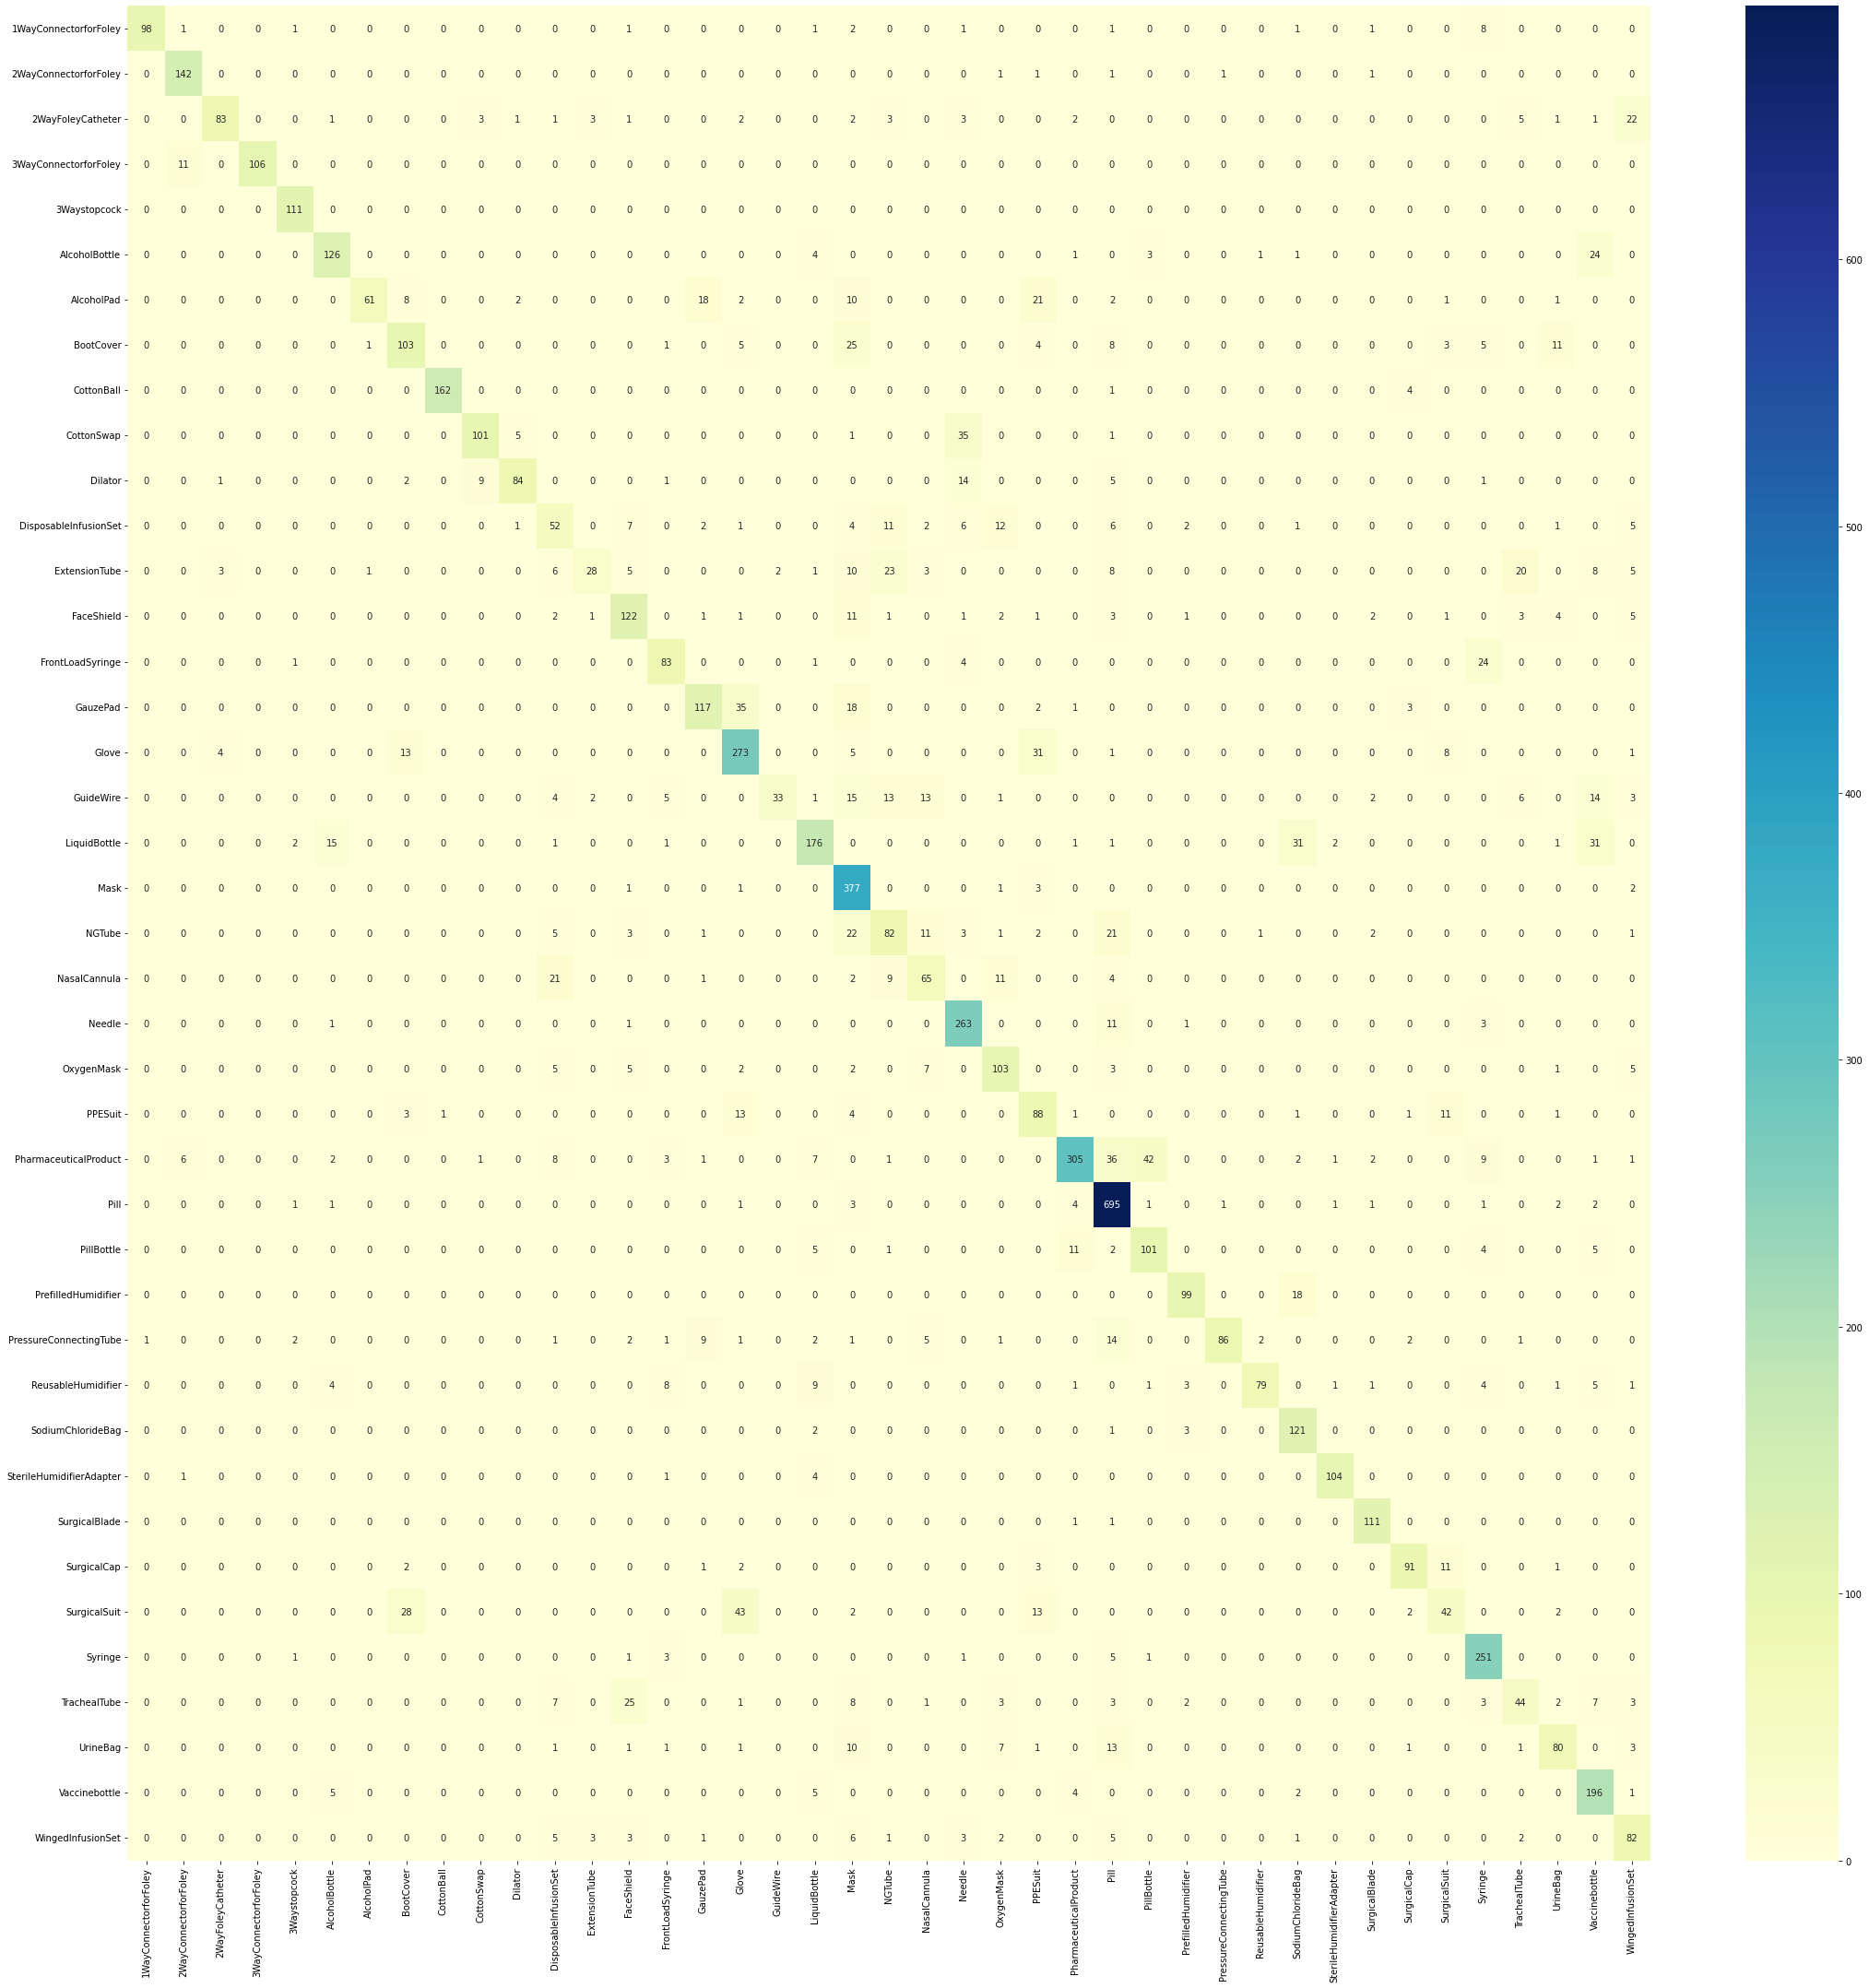

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

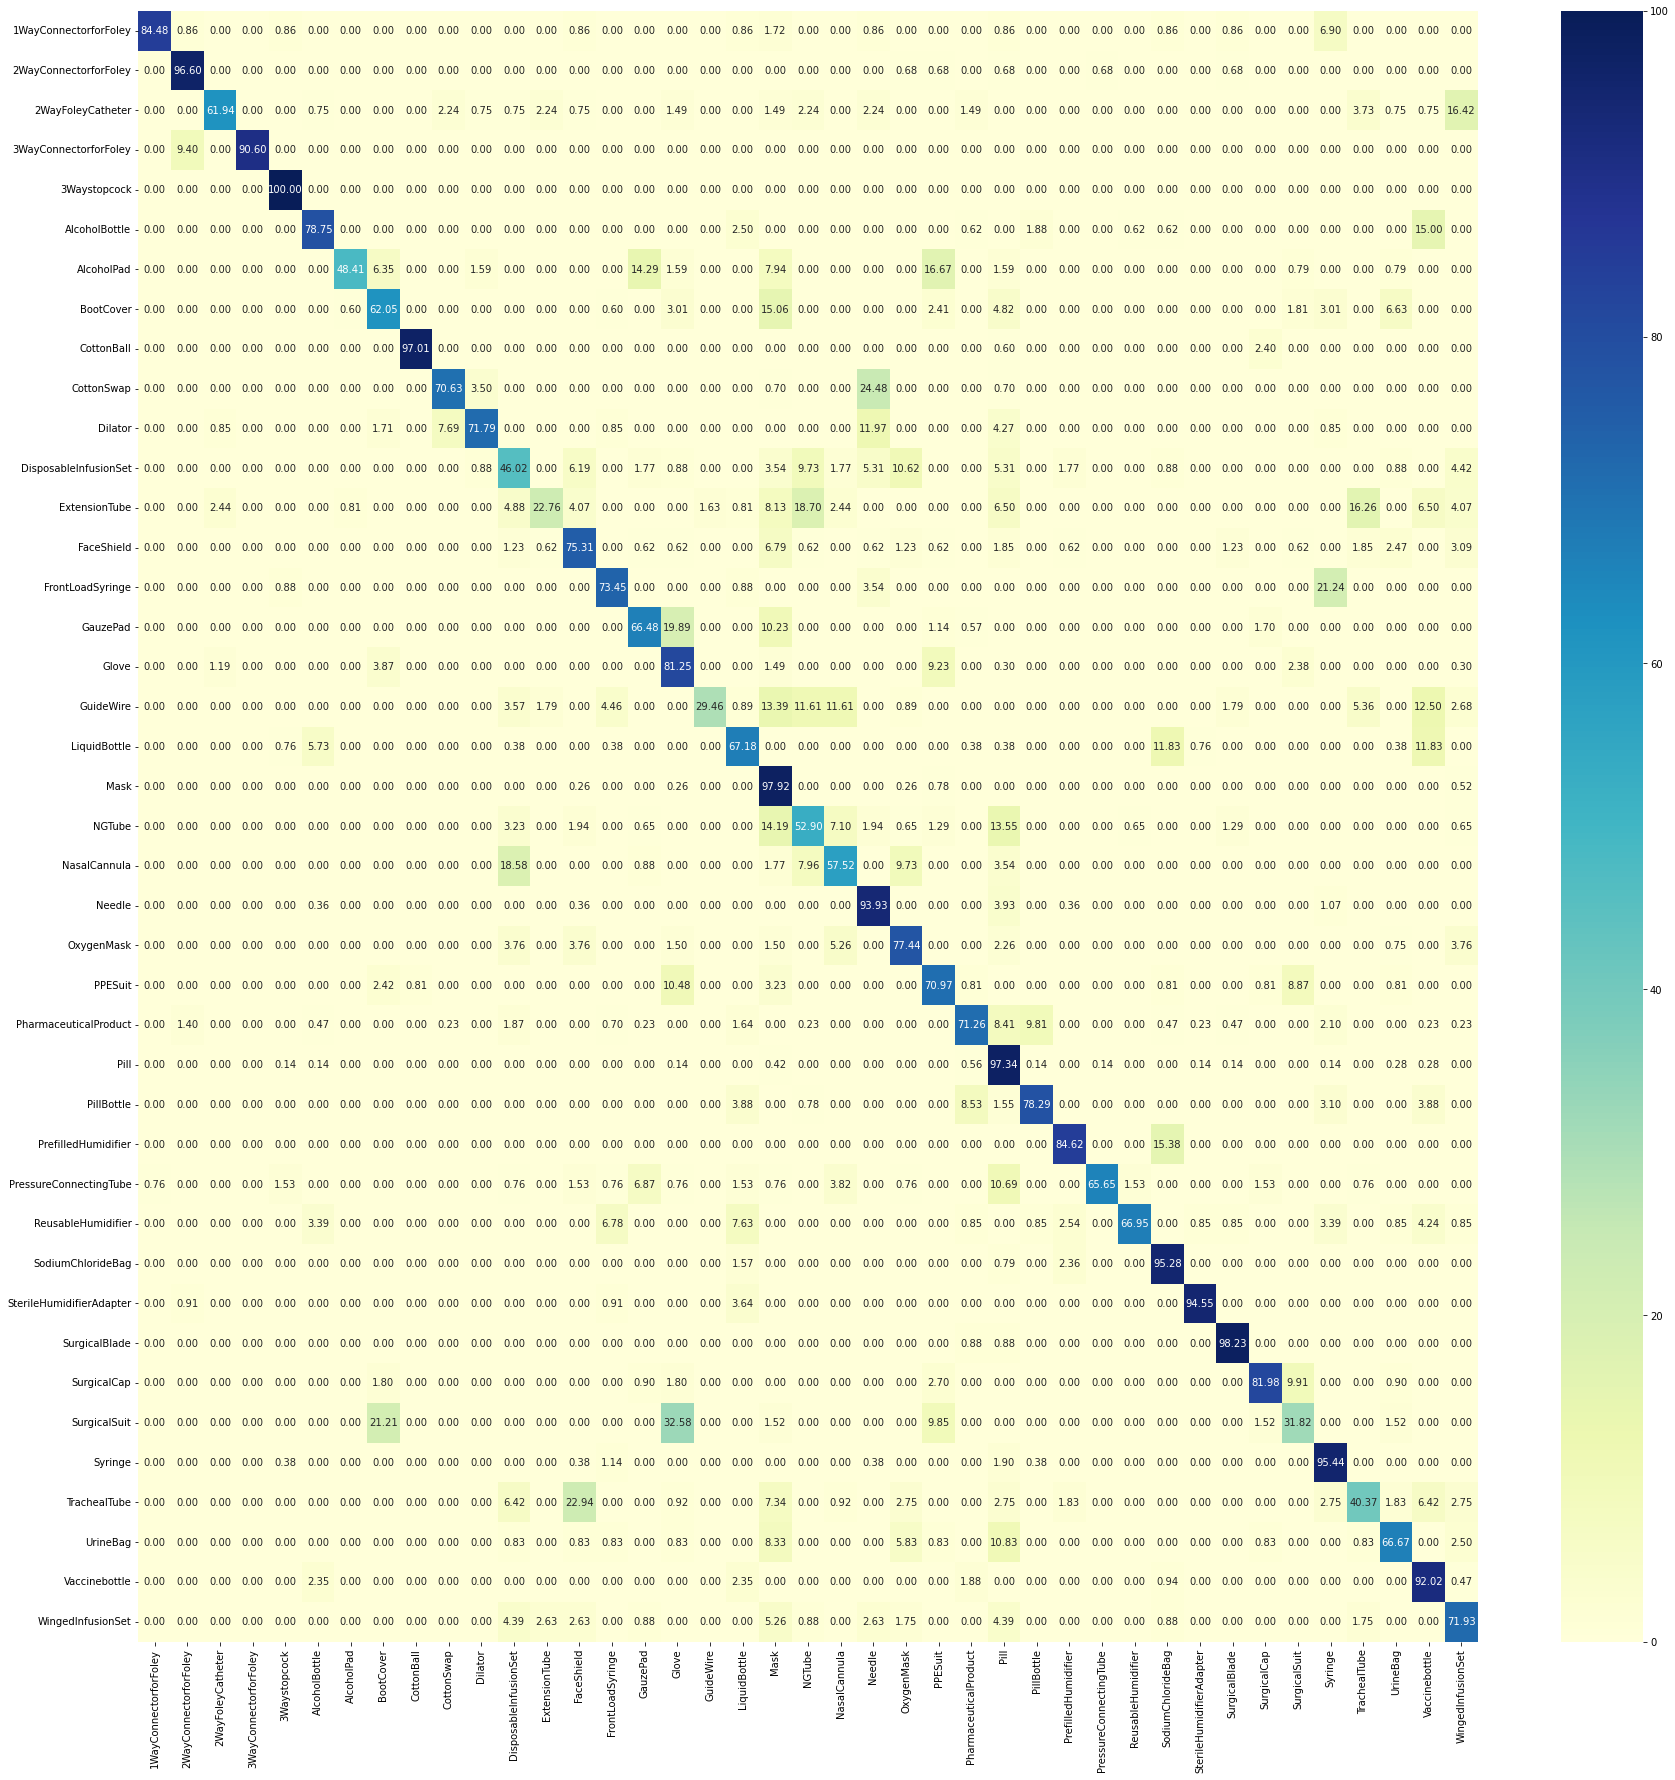

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")